In [1]:
import pickle
import os
import cv2
import numpy as np
from jax import vmap
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial

In [2]:
# init models
rngs = nnx.Rngs(0)

class AutoEncoder(nnx.Module):
    
    def __init__(self, rngs: nnx.Rngs):
    
        # define number of image channels
        self.n_channels = 3

        # define quantization
        self.K = 17

        # complexity of model 
        n_features = 32
        kernel_size = (3, 3)
        c_strides = (1, 1)
        p_strides = (2, 2)
        padding = 'SAME'
        self.activation = nnx.tanh
        self.do = nnx.Dropout(0., rngs=rngs)
        
        # Downsampling

        # pooling operation
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=p_strides, padding=padding)

        # convolutional layers
        self.conv1a = nnx.Conv(self.n_channels, n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        self.conv1b = nnx.Conv(n_features, n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        
        self.conv2a = nnx.Conv(n_features, 2 * n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        self.conv2b = nnx.Conv(2 * n_features, 2 * n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)

        # Bottleneck
        # self.bottle1 = nnx.Conv(2 * n_features, 4 * n_features, 
        #                        kernel_size=kernel_size, 
        #                        padding=padding, 
        #                        strides=c_strides,
        #                        rngs=rngs)
        # self.bottle2 = nnx.Conv(4 * n_features, 4 * n_features, 
        #                         kernel_size=kernel_size, 
        #                         padding=padding, 
        #                         strides=c_strides,
        #                         rngs=rngs)

        # Compression
        self.compress = nnx.Conv(2 * n_features, n_features // 2, 
                                 kernel_size=kernel_size, 
                                 padding=padding, 
                                 strides=c_strides,
                                 rngs=rngs)
        # self.decompress = nnx.Conv(n_features // 4, 4 * n_features, 
        #                            kernel_size=kernel_size, 
        #                            padding=padding, 
        #                            strides=c_strides,
        #                            rngs=rngs)
        
        # Upsampling
        self.upconv1 = nnx.ConvTranspose(n_features // 2, 2 * n_features, 
                                         kernel_size=kernel_size, 
                                         padding=padding, 
                                         strides=p_strides, 
                                         rngs=rngs)
        
        self.outconv1a = nnx.Conv(2 * n_features, 2 * n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides,
                                  rngs=rngs)
        self.outconv1b = nnx.Conv(2 * n_features, 2 * n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides,
                                  rngs=rngs)
          
        self.upconv2 = nnx.ConvTranspose(2 * n_features, n_features, 
                                         kernel_size=kernel_size, 
                                         padding=padding, 
                                         strides=p_strides, 
                                         rngs=rngs)
        
        self.outconv2a = nnx.Conv(n_features, n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides, 
                                  rngs=rngs)
        self.outconv2b = nnx.Conv(n_features, n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides, 
                                  rngs=rngs)

        # Final
        self.outconv3 = nnx.Conv(n_features, self.K * self.n_channels, kernel_size=(1, 1), rngs=rngs)
    
    def convnet(self, x, conv):

        # activation over convolution
        return self.do(self.activation(conv(x)))
    
    def resnet(self, x, conv):

        # activation over convolution with residual connection
        return x + self.convnet(x, conv)
    
    def __call__(self, x):

        # encoder
        
        # n_channels -> n_features 
        x = self.resnet(self.convnet(x, self.conv1a), self.conv1b)
        
        # n_features -> 2 * n_features 
        x = self.resnet(self.convnet(self.pool(x), self.conv2a), self.conv2b)

        # 2 * n_features -> 4 * n_features 
        # x = self.resnet(self.convnet(self.pool(x), self.bottle1), self.bottle2)

        # compression
        x = self.convnet(self.pool(x), self.compress)
        # x = self.convnet(x, self.decompress)
        
        # upsample
        x = self.upconv1(x)
        
        # 2 * 2 * n_features -> 2 * n_features 
        x = self.resnet(self.resnet(x, self.outconv1a), self.outconv1b)

        # upsample
        x = self.upconv2(x)
    
        # 2 * n_features -> n_features 
        x = self.resnet(self.resnet(x, self.outconv2a), self.outconv2b)
        
        # n_features -> n_channels 
        x = self.outconv3(x)

        # reshape and softmax
        B, H, W, KC = x.shape
        x = jnp.reshape(x, [B, H, W, self.n_channels, self.K])

        return x

    def encode(self, x):

        # encoder
        
        # n_channels -> n_features 
        x = self.resnet(self.convnet(x, self.conv1a), self.conv1b)
        
        # n_features -> 2 * n_features 
        x = self.resnet(self.convnet(self.pool(x), self.conv2a), self.conv2b)

        # 2 * n_features -> 4 * n_features 
        # x = self.resnet(self.convnet(self.pool(x), self.bottle1), self.bottle2)

        # compression
        x = self.convnet(self.pool(x), self.compress)
        
        return x

    def decode(self, x):
        
        # upsample
        x = self.upconv1(x)
        
        # 2 * 2 * n_features -> 2 * n_features 
        x = self.resnet(self.resnet(x, self.outconv1a), self.outconv1b)

        # upsample
        x = self.upconv2(x)
    
        # 2 * n_features -> n_features 
        x = self.resnet(self.resnet(x, self.outconv2a), self.outconv2b)
        
        # n_features -> n_channels 
        x = self.outconv3(x)

        # reshape and softmax
        B, H, W, KC = x.shape
        x = jnp.reshape(x, [B, H, W, self.n_channels, self.K])

        return x

class Unet(nnx.Module):
    
    def __init__(self, rngs: nnx.Rngs):
    
        # define number of image channels
        n_features = [16, 128, 256, 256, 256, 512]
        kernel_size = (3, 3)
        c_strides = (1, 1)
        p_strides = (2, 2)
        padding = 'SAME'
        self.activation = nnx.relu
        self.do = nnx.Dropout(0., rngs=rngs)

        # fully connected nn for time embedding
        self.dense1 = nnx.Linear(1, 32, rngs=rngs)
        self.dense2 = nnx.Linear(32, 1, rngs=rngs)
        
        # pooling operation
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=p_strides, padding=padding)

        # Initial
        in_features = n_features[0]
        
        # Downsampling
        self.down = []
        for out_features in n_features[1:-1]:

            # block includes 2 convolutional layers
            down_block = []
            
            # append convolutional layer
            down_block.append(nnx.Conv(in_features, out_features, 
                                       kernel_size=kernel_size, 
                                       padding=padding, 
                                       strides=c_strides,
                                       rngs=rngs))

            # normalize
            down_block.append(nnx.LayerNorm(out_features, rngs=rngs))

            # append second convolutional layer
            down_block.append(nnx.Conv(out_features, out_features, 
                                       kernel_size=kernel_size, 
                                       padding=padding, 
                                       strides=c_strides,
                                       rngs=rngs))

            # normalize
            down_block.append(nnx.LayerNorm(out_features, rngs=rngs))

            # append down block
            self.down.append(down_block)

            # update in features
            in_features = out_features

        # Embedding
        self.embed = nnx.Conv(in_features, n_features[-1], 
                              kernel_size=kernel_size, 
                              padding=padding, 
                              strides=c_strides,
                              rngs=rngs)
        in_features = n_features[-1]
        self.embed_norm = nnx.LayerNorm(n_features[-1], rngs=rngs)
        
        # Upsampling
        self.up = []
        for out_features in reversed(n_features[1:-1]):

            # block includes up sampling + convolution 
            up_block = []
            
            # transpose convolutional layer
            up_block.append(nnx.ConvTranspose(in_features, out_features, 
                                              kernel_size=kernel_size, 
                                              padding=padding, 
                                              strides=p_strides, 
                                              rngs=rngs))
          
            # convolutional layer
            up_block.append(nnx.Conv(2 * out_features, out_features, 
                                     kernel_size=kernel_size, 
                                     padding=padding, 
                                     strides=c_strides, 
                                     rngs=rngs))
            
            # update in features
            in_features = out_features

            # append block
            self.up.append(up_block)

        # Final
        self.outconv = nnx.Conv(in_features, n_features[0], kernel_size=(1, 1), rngs=rngs)

    def temb(self, t):

        # pass through net
        return self.dense2(nnx.tanh(self.dense1(t)))[:, jnp.newaxis, jnp.newaxis, :]
    
    def convnet(self, x, conv):

        # activation over convolution
        return self.do(self.activation(conv(x)))
    
    def resnet(self, x, conv):

        # activation over convolution with residual connection
        return x + self.convnet(x, conv)
    
    def __call__(self, x, t):

        # downsample
        save = []
        for down in self.down:
            
            # convolution + activation + dropout
            x = self.convnet(x, down[0])

            # normalize
            x = down[1](x)

            # time embedding
            x = x + self.temb(t)

            # convolution + activation + dropout
            x = self.convnet(x, down[2])

            # normalize
            x = down[3](x)
            
            # save context
            save.append(x)
            
            # pooling layer
            x = self.pool(x)

        # convolution + activation + dropout
        x = self.embed_norm(self.convnet(x, self.embed))

        # upsample
        for up, x_i in zip(self.up, reversed(save)):

            # transpose convolution
            x = self.convnet(x, up[0])
            
            # concat and convolve
            x = self.convnet(jnp.concatenate([x, x_i], -1), up[1])

        # n_features -> n_channels 
        x = self.outconv(x)

        return x

# Initialize the model
unet_model = Unet(rngs)

# Initialize the model
autoencoder = AutoEncoder(rngs)

# # Reload the object from the file
# with open("models/unet_rose.pkl", "rb") as file:
#     state = pickle.load(file)
# nnx.update(unet_model, state)

# Reload the object from the file
with open("models/autoencoder.pkl", "rb") as file:
    state = pickle.load(file)
nnx.update(autoencoder, state)

In [3]:
params = nnx.state(unet_model, nnx.Param)
total_params = np.sum([np.size(x) for x in jax.tree.leaves(params)])
total_params

np.int64(11088497)

### Import data

In [4]:
# data set of roses
img_size = 256
X = []
for fname in os.listdir("data/roses/"):
    img = cv2.imread(f"data/roses/{fname}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

    # append input and output data
    X.append(img)

    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 90, scale=1.)
    
    # Perform the rotation
    X.append(cv2.warpAffine(img, rotation_matrix, (img_size, img_size)))

    # Flip image
    X.append(cv2.flip(X[-1], 1))

    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 180, scale=1.)
    
    # Perform the rotation
    X.append(cv2.warpAffine(img, rotation_matrix, (img_size, img_size)))

    # Flip image
    X.append(cv2.flip(X[-1], 1))

    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 270, scale=1.)
    
    # Perform the rotation
    X.append(cv2.warpAffine(img, rotation_matrix, (img_size, img_size)))

    # Flip image
    X.append(cv2.flip(X[-1], 1))

X = np.stack(X)
X = (X - np.mean(X)) / np.std(X)

In [5]:
X.shape

(3045, 256, 256, 3)

### Check autoencoder reconstruction

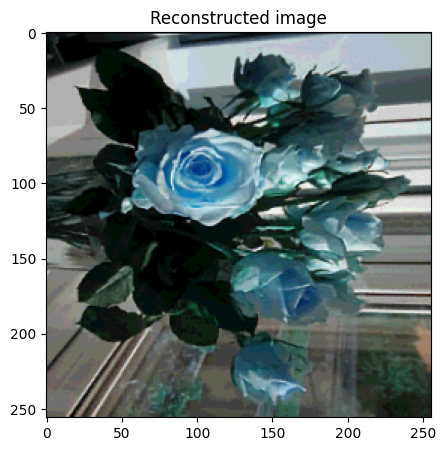

Autencoder reduces data dimension by 3.0X


In [6]:
# define quantization
filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])

# encoded data
z = autoencoder.encode(X[30:31])

# predicted
y_pred = autoencoder.decode(z)
y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

# plot
plt.figure(figsize=(5, 5))
plt.imshow(y_pred[0])
plt.title("Reconstructed image")
plt.show()

# compression factor
compression = np.size(y_pred) / np.size(z)
print(f"Autencoder reduces data dimension by {compression}X")

In [7]:
z.shape

(1, 64, 64, 16)

### Encode (discrete) image data to lower dimensional (real) space 

In [8]:
# encode (discrete) image data to lower dimensional (real) space 
N = len(X)
n_batch = 8
order = np.arange(N)

# lower dimensional data
D = np.zeros([N] + list(z.shape[1:]))  

# loop over baches of data
for batch_inds in np.array_split(order, np.ceil(N / n_batch)):

    # encode image data
    D[batch_inds] = np.array(autoencoder.encode(X[batch_inds]))

### Define parameters for diffusion process

In [9]:
# define diffusion parameters 

# number of steps
T = 1000
steps = np.arange(T)

# beta
# beta_t = .005 * np.ones(T)
beta_t = np.linspace(.0001, .02, T)

# function to compute alpha_t
alpha_t = lambda t: jnp.prod(1. - beta_t[jnp.arange(t+1)])

### Train diffusion model 

In [10]:
import optax

# number of training epochs
n_epochs = 1000

# batch size
n_batch = 16
n_batches = len(np.array_split(order, np.ceil(N / n_batch)))

# optimizer parameters
learning_rate = 0.0001
weight_decay = .0001

# optimizer = nnx.Optimizer(unet_model, optax.adamw(learning_rate, weight_decay = weight_decay))
optimizer = nnx.Optimizer(unet_model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

In [11]:
def loss_fn(model: Unet, eps, batch_z_t, batch_t):

    # predict noise
    eps_pred = model(batch_z_t, batch_t)

    # return mean squared difference
    loss = jnp.mean((eps - eps_pred) ** 2)
    
    return loss

In [12]:
@nnx.jit
def train_step(model: Unet, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, eps, batch_z_t, batch_t):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, eps, batch_z_t, batch_t)
    metrics.update(loss=loss)
    optimizer.update(grads)

    return loss

In [13]:
@nnx.jit
def mu_t(model, z, t, w1, w2):

    # compute mu_t 
    return jnp.einsum('i,ijkl->ijkl', w2, z - jnp.einsum('i,ijkl->ijkl', w1, model(z, t)))

# function to sample from latent space
def generate(model, n, temp=1.):
    
    # generate samples
    z = temp * np.random.randn(*D[[0]*n].shape)
    
    # compute chain
    for t in reversed(steps):
    
        # update z 
        if t > 0:
    
            # compute mu_t 
            w1 = np.array(n * [beta_t[t] / np.sqrt(1. - alpha_t(t))])
            w2 = np.array(n * [1./np.sqrt(1. - beta_t[t])])
            batch_steps = jnp.vstack(n * [t / (T - 1)])
            
            # sample noise
            eps = temp * np.random.randn(*z.shape) 
            z = mu_t(model, z, batch_steps, w1, w2) + np.einsum('i,ijkl->ijkl', np.array(n * [np.sqrt(beta_t[t])]), eps)
    
        # don't add noise at final step 
        else:
            w1 = np.array(n * [beta_t[t] / np.sqrt(1. - alpha_t(t))])
            w2 = np.array(n * [1./np.sqrt(1. - beta_t[t])])
            batch_steps = jnp.vstack(n * [t / (T - 1)])
            z = mu_t(unet_model, z, batch_steps, w1, w2)

    return z

In [47]:
# keep track of training loss
loss = []

# train over epochs (using dropout)
unet_model.train() 
for epoch in range(n_epochs):

    # sample image
    if epoch > 0 and epoch%50 == 0:

        # sample from latent space
        unet_model.eval() 
        z = generate(unet_model, n=1)
        unet_model.train() 

        # define quantization
        filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])
        
        # predicted
        y_pred = autoencoder.decode(z)
        y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

        plt.figure(figsize=(5, 5))
        plt.imshow(y_pred[0])
        plt.title(f"Generated image, Epoch={epoch}")
        plt.show()
    
    # random shuffling of sample index
    np.random.shuffle(order)
    
    # loop over baches of data
    epoch_loss = 0
    for batch_inds in np.array_split(order, np.ceil(N / n_batch)):
    
        # get data batch
        batch_D = D[batch_inds]
        
        # randomly sample steps
        batch_steps = np.random.choice(steps, len(batch_D)) 
        
        # diffusion kernel parameters
        A_t = np.array([alpha_t(t) for t in batch_steps])

        # sample Gaussian noise
        eps = np.random.randn(*batch_D.shape)
        
        # sample from diffusion kernel 
        e_t = np.einsum('i,ijkl->ijkl', np.sqrt(1. - A_t), eps)
        batch_z_t = np.einsum('i,ijkl->ijkl', np.sqrt(A_t), batch_D) + e_t

        # scale batch steps for input to model
        batch_steps_scaled = jnp.vstack(batch_steps) / (T - 1)
        
        # take step 
        epoch_loss += train_step(unet_model, optimizer, metrics, eps, batch_z_t, batch_steps_scaled) / n_batches

    # print progress
    loss.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.3f}")

# disable dropout
unet_model.eval()

In [15]:
unet_model.eval()

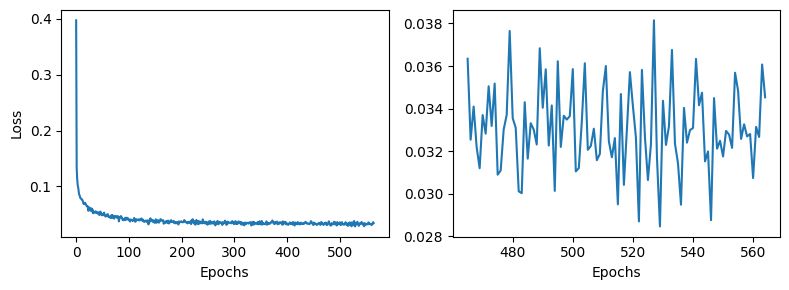

In [16]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.plot(np.array(loss)) # [-500:])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(np.arange(len(loss)-100, len(loss)), np.array(loss)[-100:])
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [31]:
import optax

# number of training epochs
n_epochs = 100

# batch size
n_batch = 16
n_batches = len(np.array_split(order, np.ceil(N / n_batch)))

# optimizer parameters
learning_rate = .00001
weight_decay = .0001

# optimizer = nnx.Optimizer(unet_model, optax.adamw(learning_rate, weight_decay = weight_decay))
optimizer = nnx.Optimizer(unet_model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

In [32]:
# keep track of training loss
loss = []

# train over epochs (using dropout)
unet_model.train() 
for epoch in range(n_epochs):
    
    # random shuffling of sample index
    np.random.shuffle(order)
    
    # loop over baches of data
    epoch_loss = 0
    for batch_inds in np.array_split(order, np.ceil(N / n_batch)):
    
        # get data batch
        batch_D = D[batch_inds]
        
        # randomly sample steps
        batch_steps = np.random.choice(steps, len(batch_D)) 
        
        # diffusion kernel parameters
        A_t = np.array([alpha_t(t) for t in batch_steps])

        # sample Gaussian noise
        eps = np.random.randn(*batch_D.shape)
        
        # sample from diffusion kernel 
        e_t = np.einsum('i,ijkl->ijkl', np.sqrt(1. - A_t), eps)
        batch_z_t = np.einsum('i,ijkl->ijkl', np.sqrt(A_t), batch_D) + e_t

        # scale batch steps for input to model
        batch_steps_scaled = jnp.vstack(batch_steps) / (T - 1)
        
        # take step 
        epoch_loss += train_step(unet_model, optimizer, metrics, eps, batch_z_t, batch_steps_scaled) / n_batches

    # print progress
    loss.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.3f}")

# disable dropout
unet_model.eval()

Epoch 1, Loss: 0.031
Epoch 2, Loss: 0.033
Epoch 3, Loss: 0.029
Epoch 4, Loss: 0.033
Epoch 5, Loss: 0.032
Epoch 6, Loss: 0.033
Epoch 7, Loss: 0.030
Epoch 8, Loss: 0.029
Epoch 9, Loss: 0.032
Epoch 10, Loss: 0.031
Epoch 11, Loss: 0.029
Epoch 12, Loss: 0.030
Epoch 13, Loss: 0.032
Epoch 14, Loss: 0.033
Epoch 15, Loss: 0.032
Epoch 16, Loss: 0.030
Epoch 17, Loss: 0.032
Epoch 18, Loss: 0.032
Epoch 19, Loss: 0.029
Epoch 20, Loss: 0.034
Epoch 21, Loss: 0.030
Epoch 22, Loss: 0.031
Epoch 23, Loss: 0.028
Epoch 24, Loss: 0.030
Epoch 25, Loss: 0.033
Epoch 26, Loss: 0.031
Epoch 27, Loss: 0.033
Epoch 28, Loss: 0.034
Epoch 29, Loss: 0.033
Epoch 30, Loss: 0.031
Epoch 31, Loss: 0.033
Epoch 32, Loss: 0.031
Epoch 33, Loss: 0.029
Epoch 34, Loss: 0.033
Epoch 35, Loss: 0.030
Epoch 36, Loss: 0.033
Epoch 37, Loss: 0.032
Epoch 38, Loss: 0.035
Epoch 39, Loss: 0.032
Epoch 40, Loss: 0.034
Epoch 41, Loss: 0.031
Epoch 42, Loss: 0.031
Epoch 43, Loss: 0.031
Epoch 44, Loss: 0.034
Epoch 45, Loss: 0.035
Epoch 46, Loss: 0.0

In [45]:
# save checkpoint
state = nnx.state(unet_model)
# Save the parameters
with open("models/unet_rose.pkl", "wb") as file:
    pickle.dump(state, file)

### Generate new sample

In [42]:
# sample from latent space
n = 16
z = generate(unet_model, n, temp=1.)

### Decode from latent space

In [43]:
# define quantization
filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])

# predicted
y_pred = autoencoder.decode(z)
y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

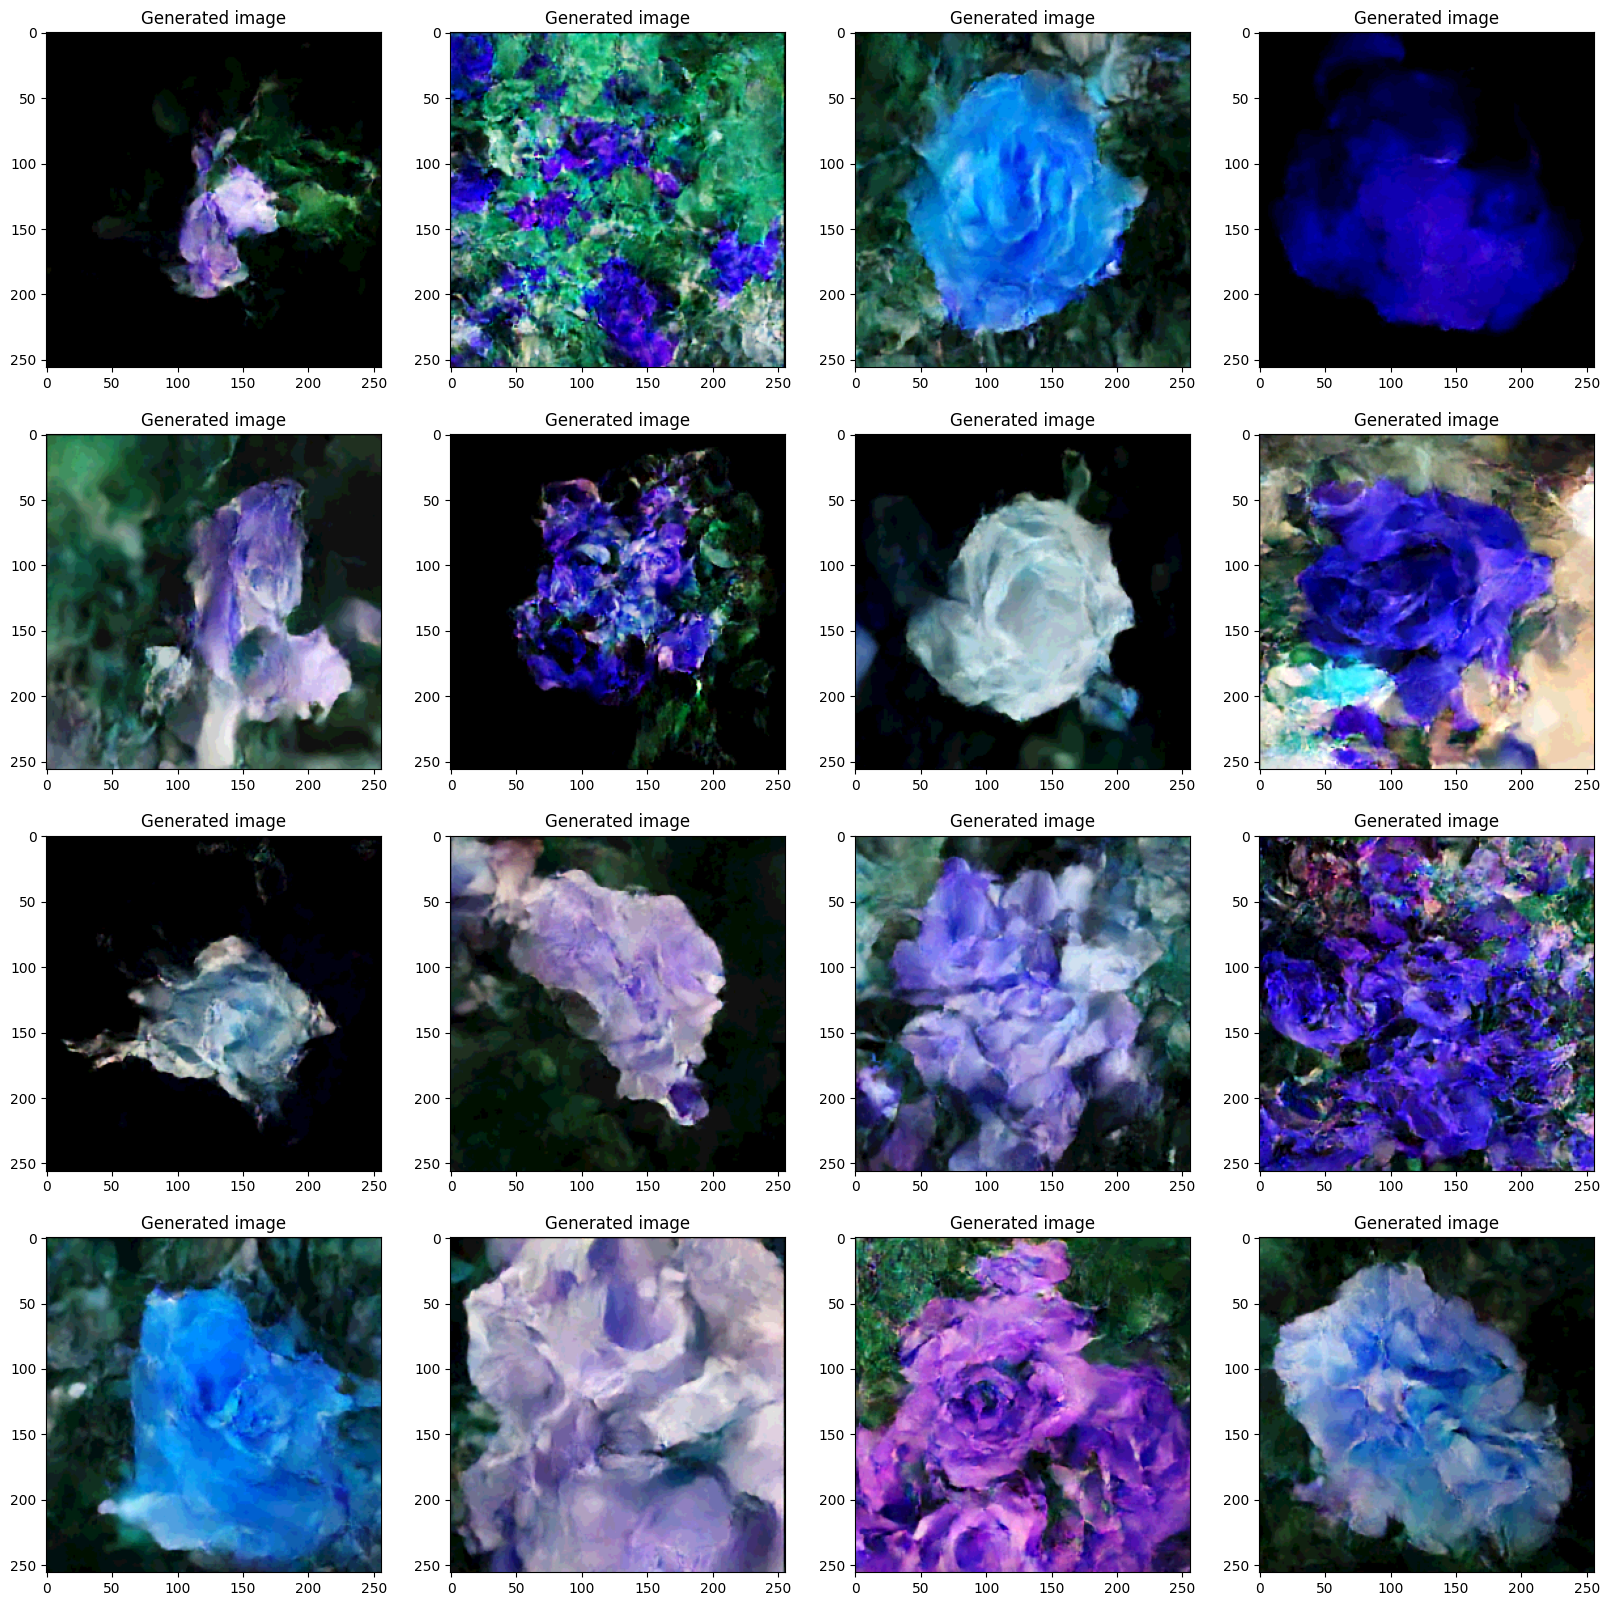

In [46]:
plt.figure(figsize=(4 * 5, 4 * 5))
for i, y_pred_i in enumerate(y_pred):
    plt.subplot(4, 4, i+1)
    plt.imshow(y_pred_i)
    plt.title("Generated image")
plt.savefig("figures/flowers.png", dpi=300)
plt.show()

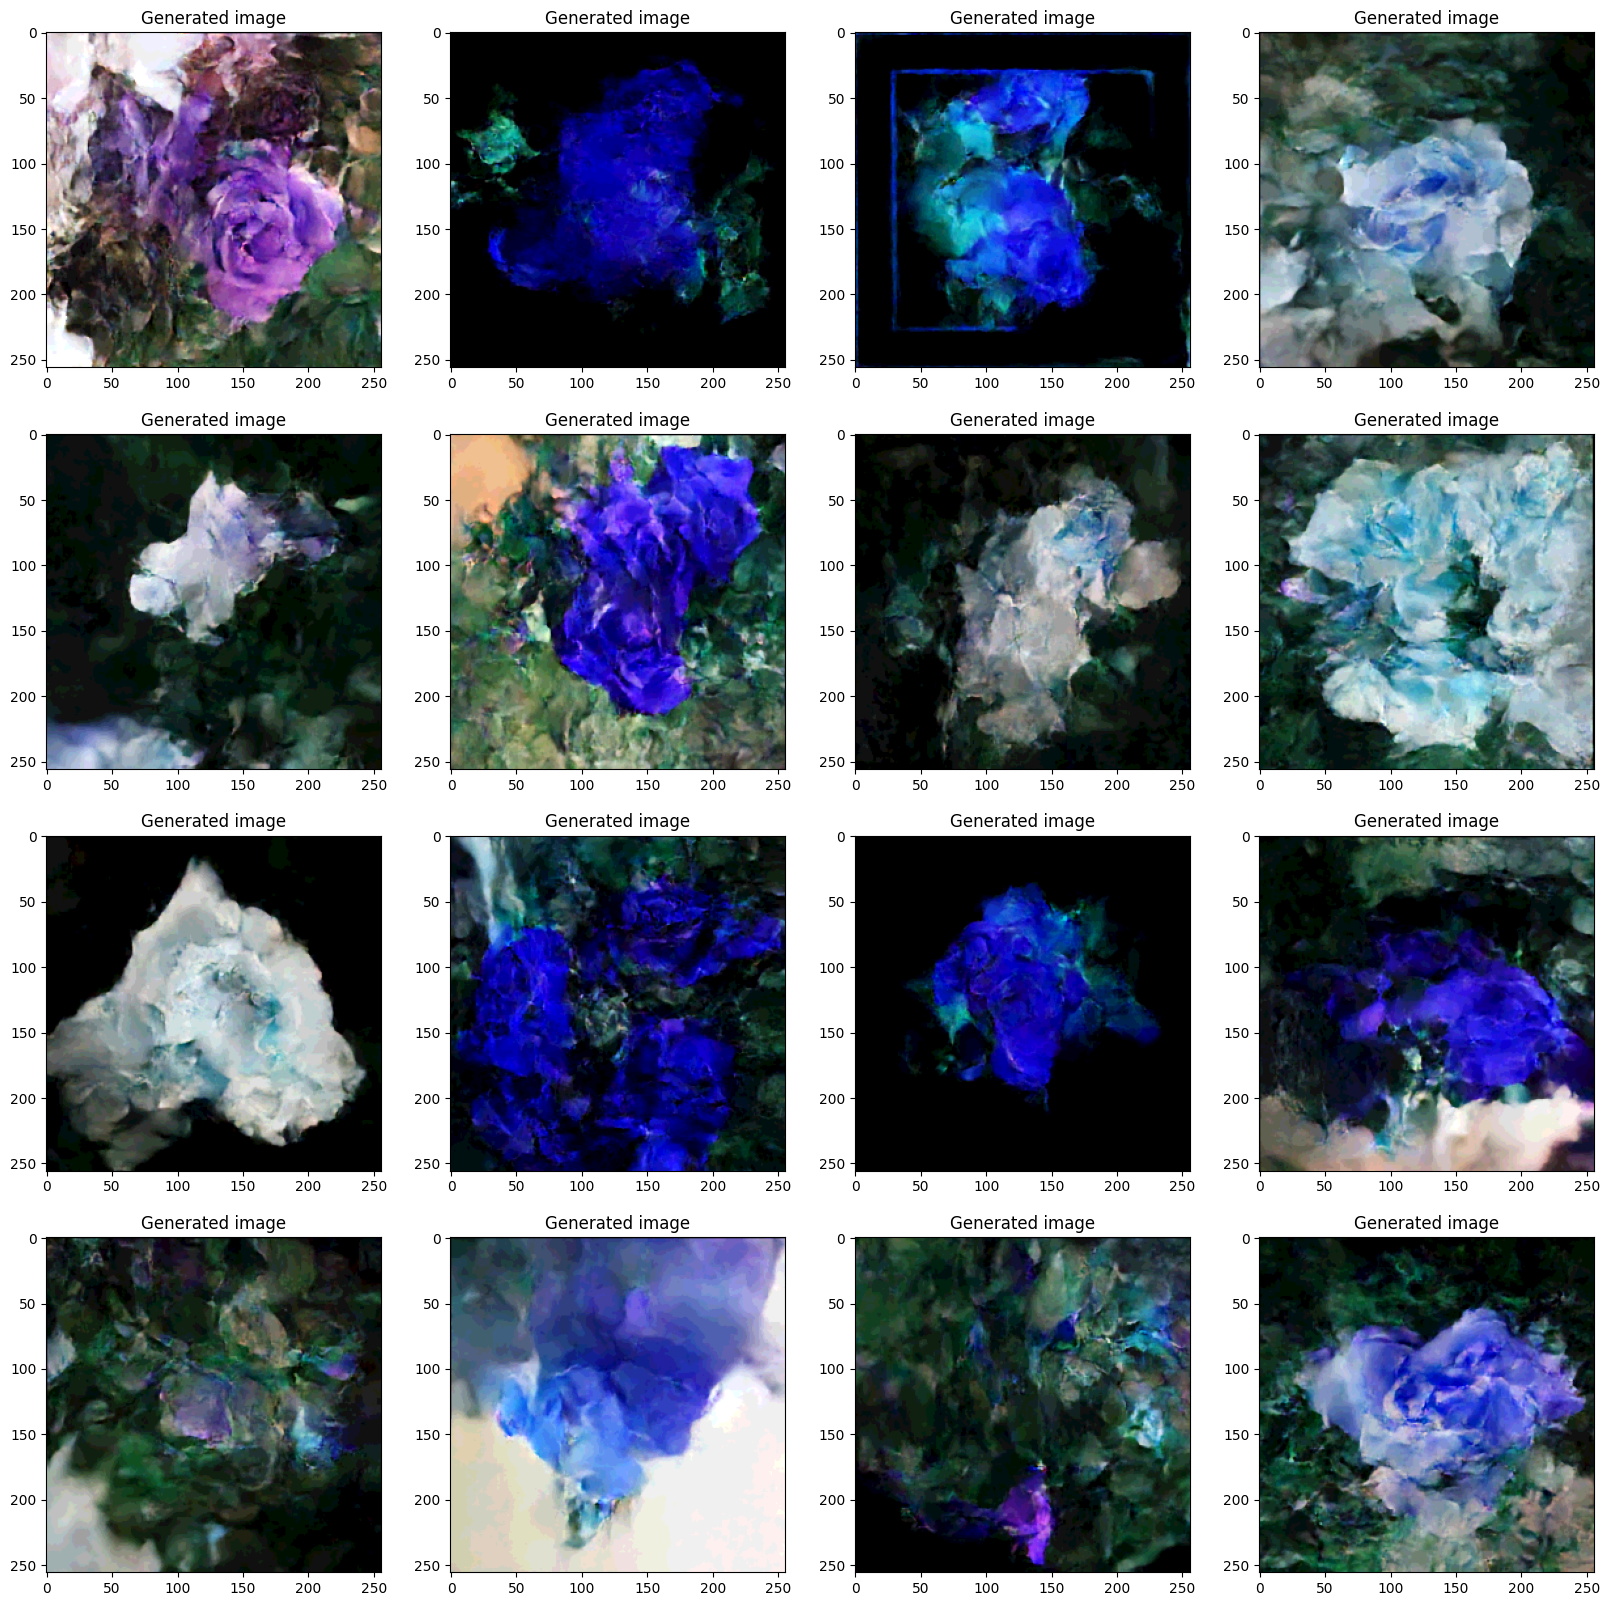

In [35]:
plt.figure(figsize=(4 * 5, 4 * 5))
for i, y_pred_i in enumerate(y_pred):
    plt.subplot(4, 4, i+1)
    plt.imshow(y_pred_i)
    plt.title("Generated image")
plt.show()

Layer norm on embedding layers results in apparent improvement over no layer norm, though it's hard to quantify. 